In [1]:
import confirm.cloud.clickhouse as ch
# client = ch.connect('wd41_4d_v0')
# ch.list_tables(client)

In [2]:
import confirm.adagrid as ada
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imprint as ip
import scipy.special
import jax

In [5]:

ip.setup_nb()

self = ada.DuckDBTiles.connect('../../wd41_4d_v55')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-03-25 05:57:04,858 - imprint - DEBUG 
Enabling 64-bit floats in JAX.


## Broad table exploration

In [6]:
n_rows_df = pd.DataFrame(
    [(table, self.con.query(f'select count(*) from {table}').fetchone()[0]) for table in ch.all_tables],
    columns=['table', 'count']
).set_index('table')
n_rows_df


,count
table,
results,64329194
tiles,124486172
done,60339479
config,1
logs,24451
reports,7927
null_hypos,2


In [8]:
from confirm.adagrid.const import MAX_STEP
n_sims = self.con.query('select sum(K) from results').fetchone()[0]
n_retained_sims = self.con.query(f'select sum(K) from results where inactivation_step={MAX_STEP}').fetchone()[0]
n_sims / 1e12, n_retained_sims / 1e12

(0.532898250752, 0.507360477184)

In [10]:
n_active_tiles = self.con.query(
    f"select count(*) from results where inactivation_step={MAX_STEP}"
).fetchone()[0]
n_eligible_tiles = self.con.query(
    f"select count(*) from results where completion_step={MAX_STEP}"
).fetchone()[0]
n_active_tiles, n_eligible_tiles

(61239938, 61239938)

In [11]:
self.con.query(f'select K, count(*) as n_tiles from tiles where inactivation_step={MAX_STEP} group by K order by K').df()

,K,n_tiles
0,8192,63372243
1,16384,772329
2,32768,5550


In [8]:
volume_sql = (
    str(2 ** self.dimension())
    + "*"
    + ("*".join([f"radii{d}" for d in range(self.dimension())]))
)

self.con.execute(f'create index if not exists volume_idx2 on results (active, ({volume_sql}))')

In [9]:
smallest_tile = self.con.query(f'select * from results where active=true order by {volume_sql} limit 1').df()
smallest_tile

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,id,active,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,creator_id,creation_time,processor_id,processing_time,eligible,grid_cost,impossible,orderer,alpha0,idx,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,...,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_lams5,twb_lams6,twb_lams7,twb_lams8,twb_lams9,twb_lams10,twb_lams11,twb_lams12,twb_lams13,twb_lams14,twb_lams15,twb_lams16,twb_lams17,twb_lams18,twb_lams19,twb_lams20,twb_lams21,twb_lams22,twb_lams23,twb_lams24,twb_lams25,twb_lams26,twb_lams27,twb_lams28,twb_lams29,twb_lams30,twb_lams31,twb_lams32,twb_lams33,twb_lams34,twb_lams35,twb_lams36,twb_lams37,twb_lams38,twb_lams39,twb_lams40,twb_lams41,twb_lams42,twb_lams43,twb_lams44,twb_lams45,twb_lams46,twb_lams47,twb_lams48,twb_lams49
0,4744574643028347040,True,4744574230711488800,-1.015625,-1.015625,-0.790625,-0.715625,0.009375,0.009375,0.009375,0.009375,True,False,524288,98,25,1,1.679655e+09,2,1.679656e+09,True,0.005084,False,0.019232,0.019916,10440,0.020152,0.019675,0.019232,0.019651,0.019889,0.019389,0.019744,0.019217,0.019736,0.019524,0.019731,0.019617,0.020007,0.019286,0.019607,0.019617,0.019602,0.019391,0.019664,0.019651,0.019627,0.019768,0.019617,0.019353,...,0.019823,0.019471,0.020097,0.019617,0.019423,0.019749,0.019769,0.01966,0.019651,0.019602,0.019751,0.019809,0.019617,0.019617,0.019232,0.019736,0.020152,0.01933,0.019809,0.019367,0.019916,0.019651,0.019888,0.019744,0.019651,0.020097,0.019651,0.019568,0.019657,0.019651,0.019736,0.019536,0.019651,0.019617,0.01952,0.019651,0.019651,0.019607,0.019876,0.019651,0.019768,0.019582,0.019809,0.019651,0.019731,0.019471,0.019736,0.019526,0.019878,0.019353


In [10]:
largest_tile = self.con.query(f'select * from results where active=true order by {volume_sql} desc limit 1').df()
largest_tile

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,id,active,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,creator_id,creation_time,processor_id,processing_time,eligible,grid_cost,impossible,orderer,alpha0,idx,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,...,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_lams5,twb_lams6,twb_lams7,twb_lams8,twb_lams9,twb_lams10,twb_lams11,twb_lams12,twb_lams13,twb_lams14,twb_lams15,twb_lams16,twb_lams17,twb_lams18,twb_lams19,twb_lams20,twb_lams21,twb_lams22,twb_lams23,twb_lams24,twb_lams25,twb_lams26,twb_lams27,twb_lams28,twb_lams29,twb_lams30,twb_lams31,twb_lams32,twb_lams33,twb_lams34,twb_lams35,twb_lams36,twb_lams37,twb_lams38,twb_lams39,twb_lams40,twb_lams41,twb_lams42,twb_lams43,twb_lams44,twb_lams45,twb_lams46,twb_lams47,twb_lams48,twb_lams49
0,4742268898425434992,True,4742268692266870002,-1.9625,-1.9625,-1.9625,-1.3625,0.0375,0.0375,0.0375,0.0375,True,False,8192,2,100,1,1.679622e+09,2,1.679622e+09,True,0.013052,False,0.009806,0.011948,96,0.01536,0.012863,0.009806,0.012892,0.012602,0.012892,0.012602,0.012892,0.01445,0.012892,0.012986,0.009198,0.012765,0.013651,0.012892,0.009858,0.011494,0.012986,0.013849,0.011609,0.012203,0.013651,0.009858,0.014762,...,0.012892,0.012835,0.012203,0.013849,0.012203,0.014731,0.013651,0.011609,0.013743,0.011609,0.01536,0.012602,0.013743,0.012203,0.012203,0.013849,0.012986,0.012602,0.013743,0.01445,0.013651,0.011002,0.014614,0.009806,0.012765,0.012602,0.011609,0.01445,0.012602,0.012892,0.012835,0.012765,0.012203,0.01154,0.012835,0.013651,0.013651,0.013651,0.011992,0.011609,0.01445,0.014306,0.012892,0.013849,0.01117,0.011609,0.011609,0.012892,0.012602,0.011992


In [11]:
lamss_tile = self.con.query('select * from results where active=true order by lams limit 1').df()
lamss_tile

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,id,active,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,creator_id,creation_time,processor_id,processing_time,eligible,grid_cost,impossible,orderer,alpha0,idx,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,...,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_lams5,twb_lams6,twb_lams7,twb_lams8,twb_lams9,twb_lams10,twb_lams11,twb_lams12,twb_lams13,twb_lams14,twb_lams15,twb_lams16,twb_lams17,twb_lams18,twb_lams19,twb_lams20,twb_lams21,twb_lams22,twb_lams23,twb_lams24,twb_lams25,twb_lams26,twb_lams27,twb_lams28,twb_lams29,twb_lams30,twb_lams31,twb_lams32,twb_lams33,twb_lams34,twb_lams35,twb_lams36,twb_lams37,twb_lams38,twb_lams39,twb_lams40,twb_lams41,twb_lams42,twb_lams43,twb_lams44,twb_lams45,twb_lams46,twb_lams47,twb_lams48,twb_lams49
0,4744607559657468077,True,4744607422218503051,-0.0875,-0.0875,0.1375,0.2875,0.0375,0.0375,0.0375,0.0375,True,True,32768,99,89,1,1.679656e+09,2,1.679656e+09,True,0.016112,False,0.00257,0.008888,290,0.003491,0.002779,0.00257,0.002629,0.002634,0.002611,0.002602,0.002629,0.002958,0.003121,0.002617,0.002736,0.003348,0.002942,0.002632,0.002632,0.002625,0.002628,0.003562,0.003121,0.002584,0.002602,0.002586,0.002723,...,0.002841,0.002628,0.00257,0.002632,0.002628,0.002792,0.002573,0.002603,0.002629,0.002868,0.002723,0.003117,0.002625,0.003263,0.002634,0.002599,0.002844,0.002723,0.002586,0.002942,0.002632,0.002841,0.002615,0.002625,0.002605,0.002573,0.003096,0.002632,0.002621,0.002632,0.002625,0.003263,0.002958,0.002599,0.002629,0.002628,0.003263,0.002629,0.002602,0.002634,0.002625,0.003348,0.002841,0.003491,0.003117,0.002844,0.002723,0.002958,0.002615,0.002844


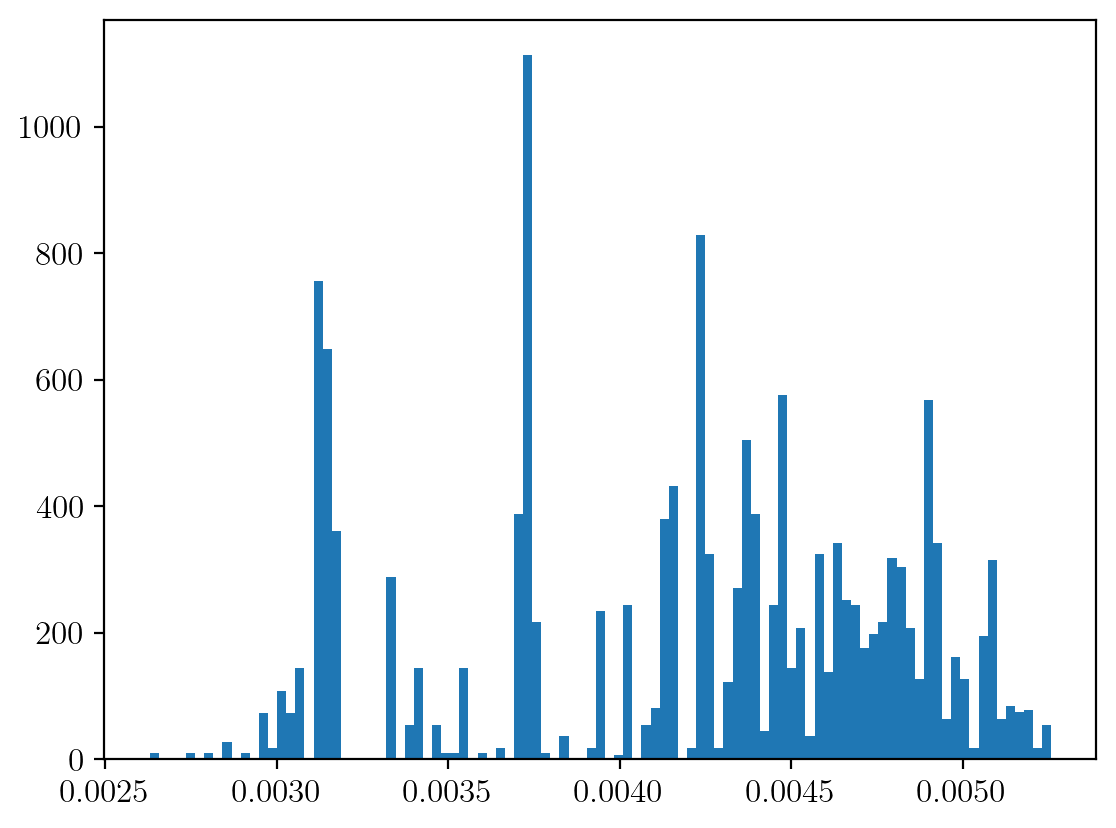

In [12]:
lams = self.con.query('select lams from results where active=true').df()
lamss = lams['lams'].min()
max_display = lamss * 2
plt.hist(lams['lams'], bins=np.linspace(lamss, max_display, 100))
plt.show()

## Ordering

In [6]:
worst5000_df = self.con.query('select * from results where active=true order by lams limit 5000').df()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [9]:
orderer_df = self.con.query(
    f"select orderer from results where active=true and orderer <= {worst5000_df['orderer'].max()} order by orderer"
).df()


In [12]:
wait = np.searchsorted(orderer_df['orderer'], worst5000_df['orderer'])
wait

array([  36,   36,   36,   36,   36,   36,   36,   36,   36,    0, ..., 5529, 5529, 5529, 5529,
       5529, 5529, 5529, 5529, 3744, 3744])

In [15]:
cfg = self.get_config().iloc[0].to_dict()

In [47]:
import confirm.adagrid.calibrate as adacal
import confirm.models.wd41 as wd41
report = dict()
algo = adacal.AdaCalibrate(wd41.WD41(0, 600000, ignore_intersection=True), None, self, cfg, None)


In [48]:
tiles_df = self.next(10, 11, 50000, 'orderer')
twb_worst_tile = self.worst_tile(10, "twb_mean_lams")
# np.sum(tiles_df['twb_min_lams'] > twb_worst_tile['twb_mean_lams'].iloc[0])

In [51]:
self = algo
twb_worst_tile = self.db.worst_tile(10, "twb_mean_lams")
for col in twb_worst_tile.columns:
    if col.startswith("radii"):
        twb_worst_tile[col] = 1e-6
twb_worst_tile["K"] = self.max_K
twb_worst_tile_lams = self.driver.bootstrap_calibrate(
    twb_worst_tile,
    self.cfg["alpha"],
    calibration_min_idx=self.cfg["calibration_min_idx"],
    tile_batch_size=1,
)
twb_worst_tile_mean_lams = twb_worst_tile_lams["twb_mean_lams"].iloc[0]
deepen_likely_to_work = tiles_df["twb_min_lams"] > twb_worst_tile_mean_lams

In [53]:
np.sum(deepen_likely_to_work)

0

## Investigating the WD41 problem.

In [13]:
import confirm.models.wd41 as wd41

lamss_potential = lamss_tile.copy()
for d in range(self.dimension()):
    lamss_potential[f"radii{d}"] = 1e-7
cal_df = ip.calibrate(
    wd41.WD41,
    g=ip.Grid(lamss_potential, 1),
    model_kwargs={"ignore_intersection": True, "dtype": np.float64},
)

In [15]:
debug_df = pd.concat(
    (
        lamss_potential[
            [f"theta{d}" for d in range(self.dimension())]
            + [f"radii{d}" for d in range(self.dimension())]
        ],
        cal_df,
    ),
    axis=1,
)
for d in range(self.dimension()):
    name = ['p_{hr+, c}', 'p_{hr+, t}', 'p_{tnbc, c}', 'p_{tnbc, t}'][d]
    debug_df[name] = scipy.special.expit(debug_df[f"theta{d}"])
debug_df.drop(columns=[f"theta{d}" for d in range(self.dimension())], inplace=True)
debug_df

,radii0,radii1,radii2,radii3,lams,alpha0,idx,K,"p_{hr+, c}","p_{hr+, t}","p_{tnbc, c}","p_{tnbc, t}"
0,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.009954,0.025,818,32768,0.478139,0.478139,0.534321,0.571384


In [62]:
model = wd41.WD41(0, 10000, ignore_intersection=True)
g_explore = ip.cartesian_grid([-0.6, -1.5875, -0.6, 0.5125], [-0.4, -1.5875, -0.4, 0.5125], n=[10, 1, 10, 1], null_hypos=model.null_hypos)
cal_df = ip.calibrate(wd41.WD41, g=g_explore, model_kwargs={"ignore_intersection": True, "dtype": np.float64})
cal_df = pd.concat((g_explore.df, cal_df), axis=1)

In [63]:
cal_df['lams'].min()

0.023835260382475913

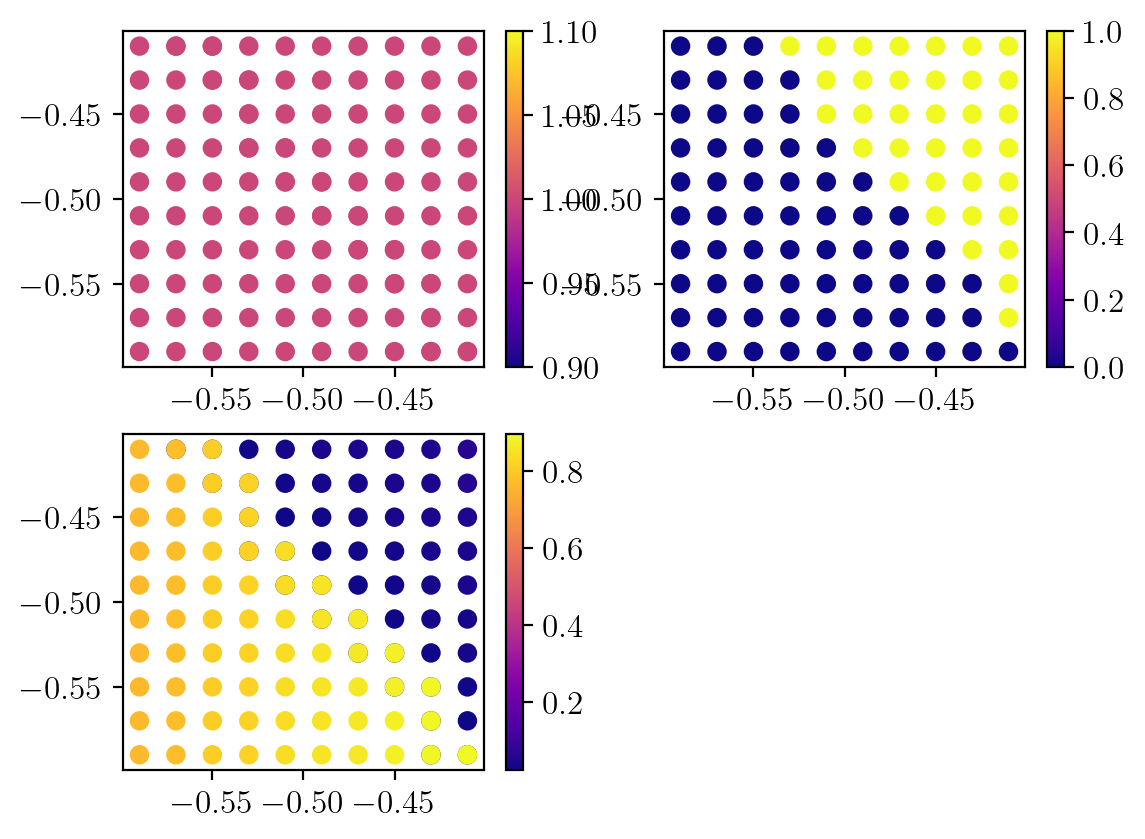

In [64]:
plt.subplot(2,2,1)
plt.scatter(cal_df['theta0'], cal_df['theta2'], c=cal_df['null_truth0'])
plt.colorbar()
plt.subplot(2,2,2)
plt.scatter(cal_df['theta0'], cal_df['theta2'], c=cal_df['null_truth1'])
plt.colorbar()
plt.subplot(2,2,3)
plt.scatter(cal_df['theta0'], cal_df['theta2'], c=cal_df['lams'])
plt.colorbar()
plt.show()

In [65]:
p = scipy.special.expit(g_explore.get_theta()[40])
sim_vmap = jax.vmap(model.sim, in_axes=(0, None, None, None, None, None))
stats = sim_vmap(model.unifs, *p, True)
# print(np.percentile(stats, 99))
# plt.plot(np.sort(stats[0]))
# plt.show()

In [66]:
bad_idx = stats['full_stat'].argmin()
model.sim(model.unifs[bad_idx], *p, True)

{'hypotnbc_live': Array(False, dtype=bool),
 'hypofull_live': Array(True, dtype=bool),
 'hyptnbc_zstat': Array(0.57977104, dtype=float32),
 'hypfull_zstat': Array(3.5796573, dtype=float32),
 'tnbc_stat': Array(0.2810345, dtype=float32),
 'full_stat': Array(0.00017202, dtype=float32),
 'ztnbc_stage1': Array(0., dtype=float32),
 'ztnbc_stage2': Array(0.81992006, dtype=float32),
 'zfull_stage1': Array(1.7075366, dtype=float32),
 'zfull_stage2': Array(3.3548632, dtype=float32)}

0.737039104104042
6.455732336689835e-06


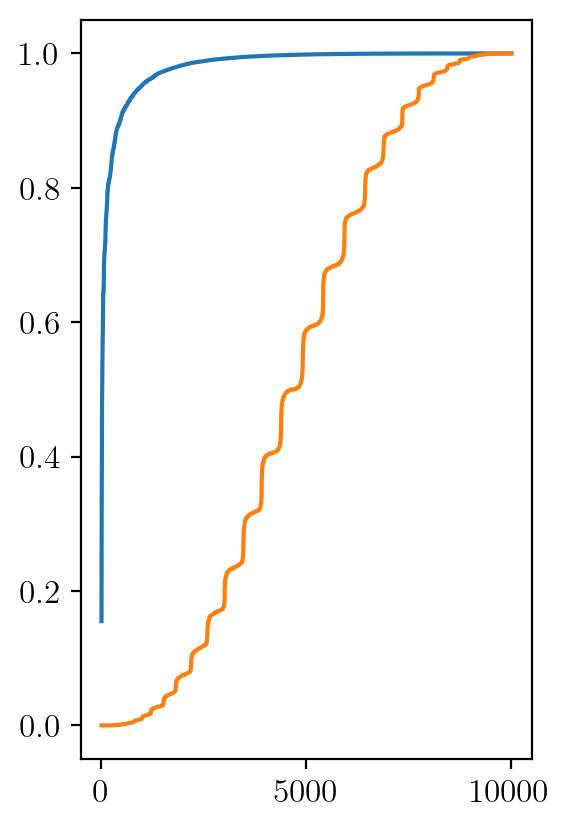

In [112]:
print(np.percentile(stats['tnbc_stat'], 1))
print(np.percentile(stats['full_stat'], 1))
plt.subplot(1,2,1)
plt.plot(np.sort(stats['tnbc_stat']))
plt.subplot(1,2,1)
plt.plot(np.sort(stats['full_stat']))
plt.show()

## Looking at the reports

In [12]:
report_df = self.get_reports()
working_reports = report_df[report_df['status'] == 'WORKING'].dropna(axis=1, how='all')
new_step_reports = report_df[report_df['status'] == 'NEW_STEP'].dropna(axis=1, how='all')

In [13]:
sim_runtime = working_reports['runtime_simulating'].sum()
total_runtime = report_df.iloc[-1]['time'] - report_df.iloc[0]['time']
parallelism = sim_runtime / total_runtime
parallelism, sim_runtime / 3600, total_runtime / 3600

(1.252935444692007, 4.0501718672778875, 3.2325463250610564)

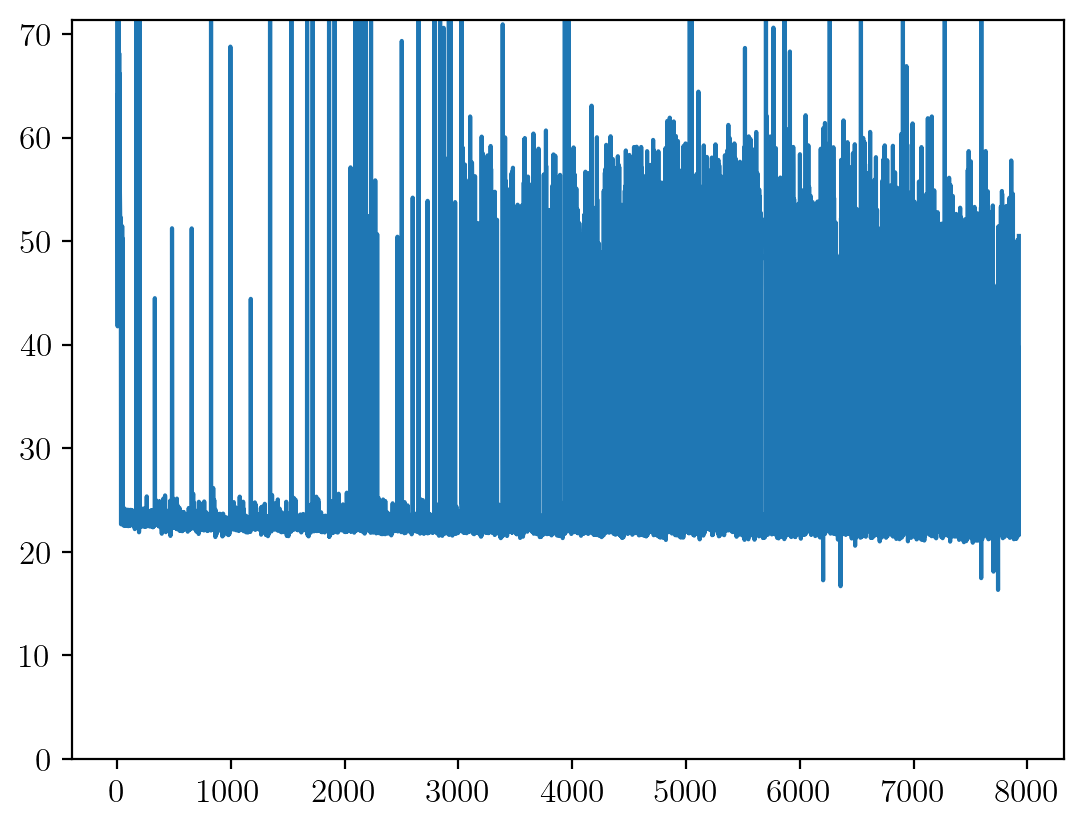

In [14]:
plt.plot(working_reports['runtime_per_sim_ns'])
plt.ylim([0, np.percentile(working_reports['runtime_per_sim_ns'], 99.5)])
plt.show()

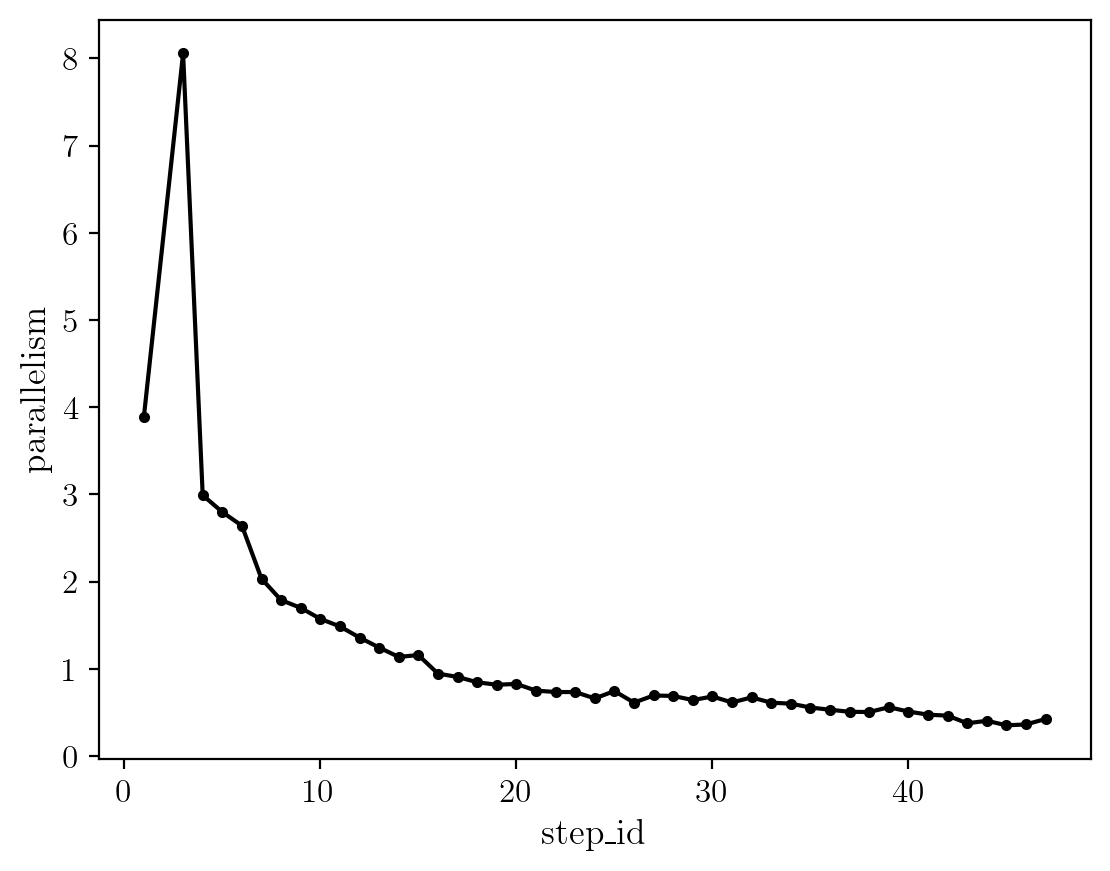

In [15]:
max_working_time = working_reports.groupby('step_id')['time'].max()
total_sim_time = working_reports.groupby('step_id')['runtime_simulating'].sum()
ex_df = new_step_reports[['step_id', 'runtime_total', 'time']].set_index('step_id')
ex_df['max_working_time'] = max_working_time
ex_df['total_sim_time'] = total_sim_time
step_parallelism = ex_df['total_sim_time'] / ((ex_df['max_working_time'] - ex_df['time']) + ex_df['runtime_total'])
plt.plot(step_parallelism, 'k-o', markersize=3)
plt.xlabel('step_id')
plt.ylabel('parallelism')
plt.show()

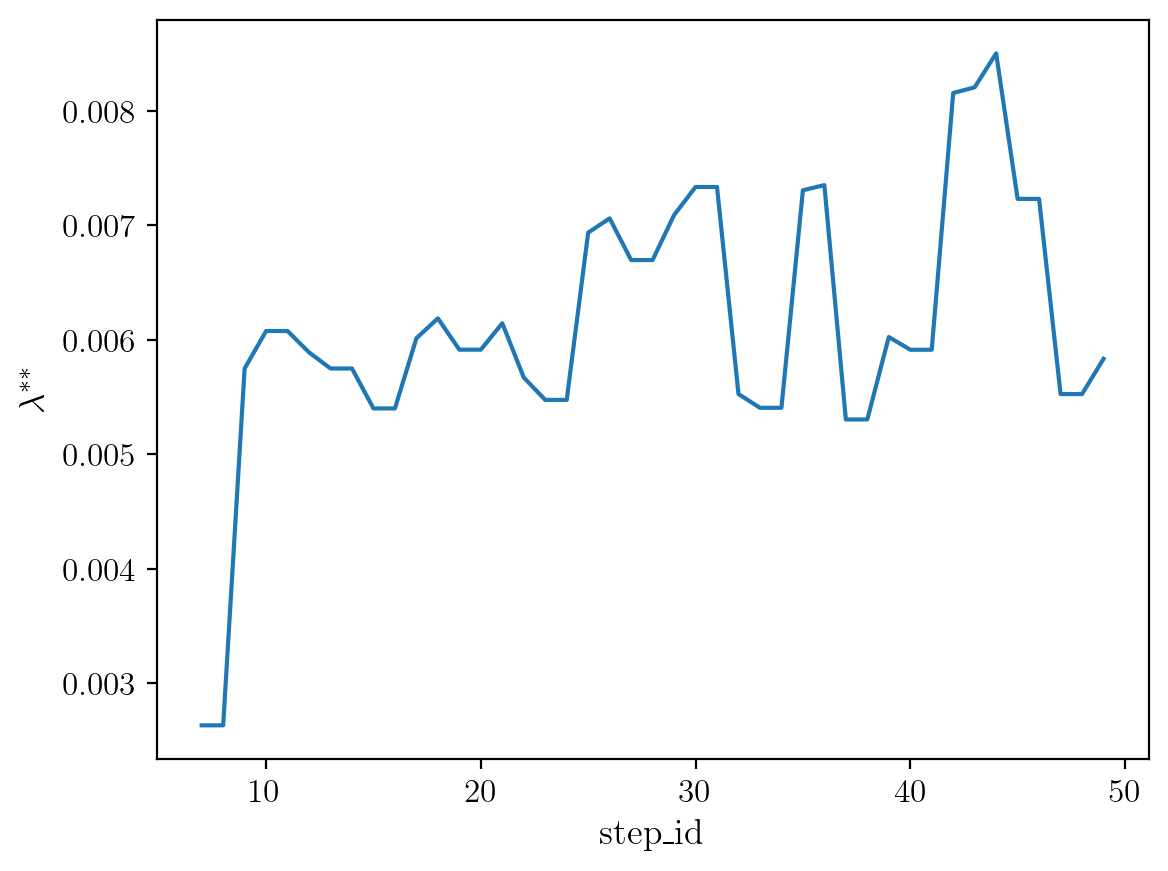

In [16]:
plt.plot(new_step_reports[['step_id', 'lamss']].set_index('step_id'))
plt.xlabel('step_id')
plt.ylabel('$\lambda^{**}$')
plt.show()

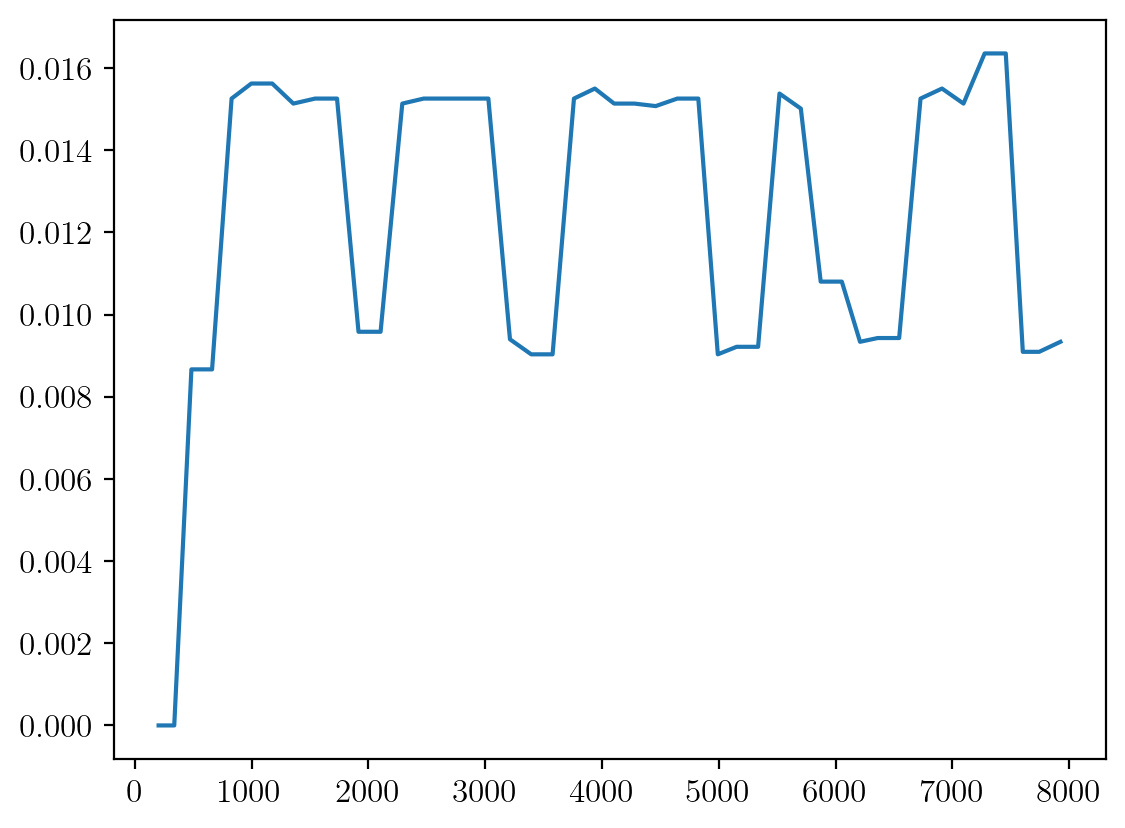

In [17]:
plt.plot(new_step_reports['tie_{k}(lamss)'])
plt.show()

In [19]:
import numpy as np
xs = np.linspace(-2, 1, 10)
ys = np.linspace(-2, 1, 10)
counts = np.empty((len(xs), len(ys)))
for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        NN = self.con.query(f'''
            select count(*) 
                from results
                where 
                    inactivation_step={MAX_STEP}
                    and abs(theta0 - {x}) < 0.167
                    and abs(theta2 - {y}) < 0.167
        ''').fetchone()[0]
        counts[i, j] = NN

In [20]:
counts.sum() / 1e6

61.254279

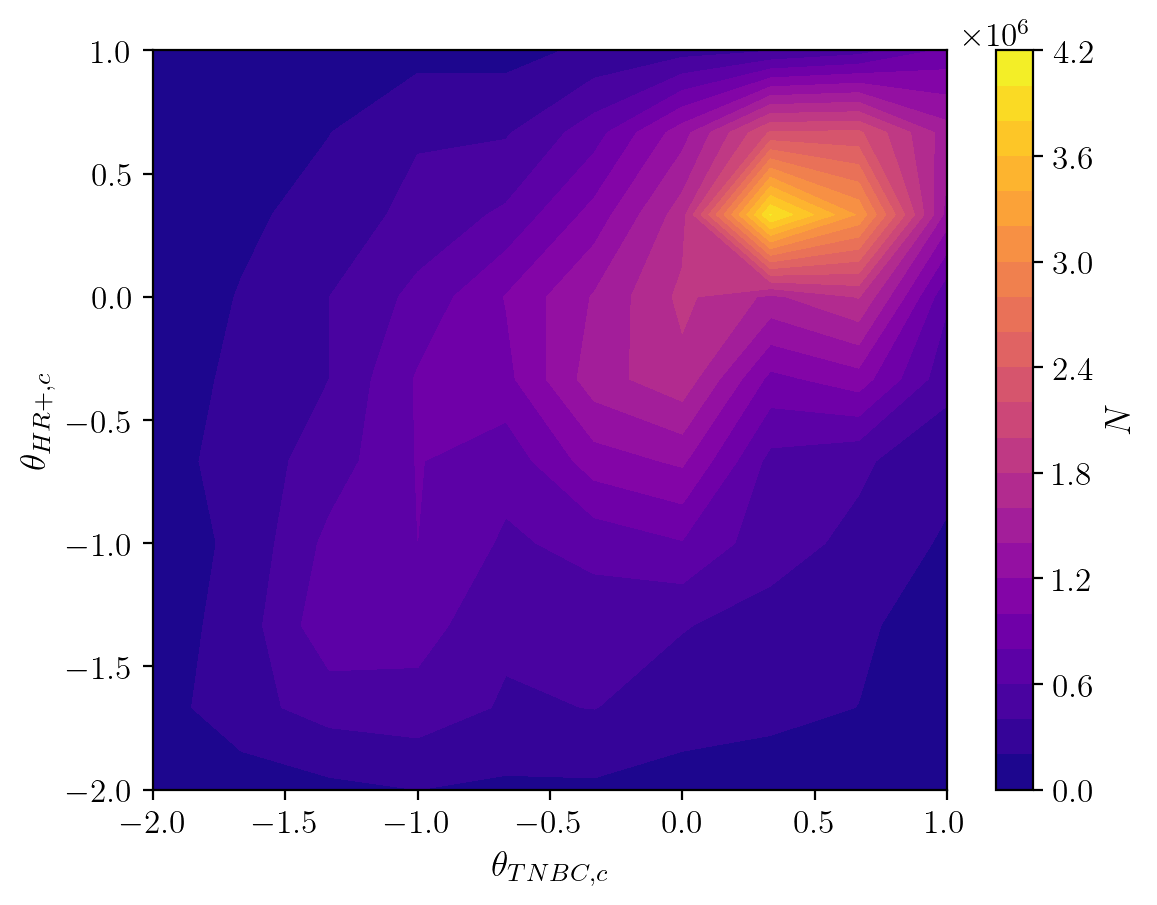

In [21]:
XX, YY = np.meshgrid(xs, ys, indexing='ij')
# plt.scatter(XX.ravel(), YY.ravel(), c=counts.ravel())
plt.contourf(XX, YY, counts, levels=20)
plt.xlabel('$\\theta_{TNBC, c}$')
plt.ylabel('$\\theta_{HR+, c}$')
cbar = plt.colorbar()
cbar.set_label('$N$')
plt.show()

In [22]:
plot_df = self.con.query('''
    select theta0, theta1, theta2, theta3, 
            radii0, radii1, radii2, radii3, 
            alpha0, K, lams, twb_mean_lams, twb_min_lams 
        from results
        where 
            abs(theta0 + 1) < 0.05
            and abs(theta2 + 1) < 0.05
''').df()

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['K'], s=5)
plt.colorbar()
plt.subplot(2, 2, 2)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['alpha0'], s=5)
plt.colorbar()
plt.subplot(2, 2, 3)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['lams'], s=5)
plt.colorbar()
plt.subplot(2, 2, 4)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['twb_min_lams'], s=5)
plt.colorbar()
plt.show()